In [1]:

#%% 
import pandas as pd
import pickle
import sqlite3
import os
import numpy as np
import sys
import gensim
import matplotlib.pyplot as plt

import tmtoolkit

sys.path.append(r'C:\Users\aspit\Git\MHDLab-Projects\Energy Storage\nlp_utils')

data_folder = r'C:\Users\aspit\Git\MHDLab-Projects\Energy Storage\data'

con = sqlite3.connect(os.path.join(data_folder, 'nlp.db'))
cursor = con.cursor()

df = pd.read_sql_query("SELECT * FROM texts", con, index_col='ID')
df_tsne = pd.read_sql_query("SELECT * FROM Kmeans_tsne", con, index_col='ID')

df = pd.concat([df, df_tsne], axis=1).dropna(subset=['processed_text'])

# df = df.sample(500, random_state=1)
df = df.dropna(subset=['processed_text'])

texts = df['processed_text'].values
texts = [t.split() for t in texts]


In [2]:
#GEnsim top terms snippet


# import itertools
# from collections import defaultdict

# total_count = defaultdict(int)
# for word_id, word_count in itertools.chain.from_iterable(data_words):
#     total_count[word_id] += word_count

# # Top ten words
# top_terms_id = sorted(total_count.items(), key=lambda x: x[1], reverse=True)[:10]

# top_terms = [(id2word[t[0]], t[1]) for t in top_terms_id]


In [3]:
thresholds = np.logspace(-3,2,6)
thresholds


array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [4]:
from tmtoolkit.topicmod.tm_gensim import compute_models_parallel


dtms = {}
vocabs = {}
bigram_texts = {}


for threshold in thresholds:

    bigram = gensim.models.Phrases(texts, threshold=threshold, min_count=5)
    bigram_mod = gensim.models.phrases.Phraser(bigram)

    texts_bigram = [bigram_mod[doc] for doc in texts]

    id2word = gensim.corpora.Dictionary(texts_bigram)
    data_words = [id2word.doc2bow(doc) for doc in texts_bigram]

    dtm = gensim.matutils.corpus2csc(data_words).astype(int).T

    dtms[threshold] = dtm

    voc = [id2word[i] for i in range(dtm.shape[1])]
    voc = np.array(voc)
    vocabs[threshold] = voc

    bigram_texts[threshold] = texts_bigram

In [5]:
lda_kwargs = {
    'passes': 5,
    'num_topics': 20,
    'alpha': 0.01,
    'eta': 0.01
    }


models = compute_models_parallel(dtms, constant_parameters=lda_kwargs)

In [6]:
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words
models

defaultdict(list,
            {1.0: [({'passes': 5,
                'num_topics': 20,
                'alpha': 0.01,
                'eta': 0.01},
               <gensim.models.ldamodel.LdaModel at 0x26e0cd181c8>)],
             0.01: [({'passes': 5,
                'num_topics': 20,
                'alpha': 0.01,
                'eta': 0.01},
               <gensim.models.ldamodel.LdaModel at 0x26e0cd18cc8>)],
             0.1: [({'passes': 5,
                'num_topics': 20,
                'alpha': 0.01,
                'eta': 0.01},
               <gensim.models.ldamodel.LdaModel at 0x26e0cd18548>)],
             0.001: [({'passes': 5,
                'num_topics': 20,
                'alpha': 0.01,
                'eta': 0.01},
               <gensim.models.ldamodel.LdaModel at 0x26e0cd18708>)],
             10.0: [({'passes': 5,
                'num_topics': 20,
                'alpha': 0.01,
                'eta': 0.01},
               <gensim.models.ldamodel.LdaModel at 0x26e0

In [7]:
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words

from tmtoolkit.topicmod.model_stats import topic_word_relevance
from tmtoolkit.topicmod.model_stats import most_relevant_words_for_topic, \
    least_relevant_words_for_topic

from tmtoolkit.topicmod.model_io import ldamodel_top_topic_words

top_words = {}

coherences_umass = pd.Series(index=thresholds)
coherences_cv = pd.Series(index=thresholds)


for threshold in models:
    mod = models[threshold][0][1]
    voc = vocabs[threshold]

    topic_term = mod.get_topics()

    doc_topic = list(mod.get_document_topics(data_words, minimum_probability=0))
    doc_topic = gensim.matutils.corpus2csc(doc_topic).T

    doc_lengths_bg = doc_lengths(dtm)
    topic_labels = generate_topic_labels_from_top_words(
        topic_term,
        doc_topic.toarray(),
        doc_lengths_bg,
        voc,
        lambda_=0.6,
        n_words = 5
    )

    topic_word_rel = topic_word_relevance(topic_term, doc_topic.toarray(), doc_lengths_bg, lambda_=0.5)

    df_top = ldamodel_top_topic_words(topic_word_rel, voc, top_n=5)
    
    top_words[threshold]  = df_top

    bigram_text = bigram_texts[threshold]

    lda_coherence_model = gensim.models.CoherenceModel(mod, coherence='u_mass',texts=bigram_text, dictionary = id2word)
    coherence = lda_coherence_model.get_coherence()
    coherences_umass.loc[threshold] = coherence

    

    lda_coherence_model = gensim.models.CoherenceModel(mod, coherence='c_v', texts=bigram_text, dictionary = id2word)
    coherence = lda_coherence_model.get_coherence()
    coherences_cv.loc[threshold] = coherence


C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if sys.path[0] == '':
C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]
C:\Users\aspit\anaconda3\envs\nlp_scraping\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\aspit\anaconda3\envs\nlp_scraping\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv

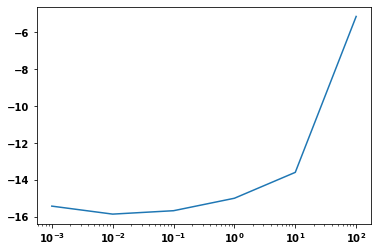

In [8]:
coherences_umass.plot()
plt.xscale('log')

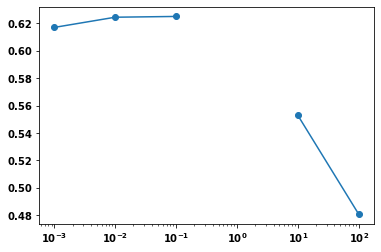

In [13]:
#Why are some of the points missing?

coherences_cv.plot(marker='o')
plt.xscale('log')

In [10]:
top_words[1e-1]

,rank_1,rank_2,rank_3,rank_4,rank_5
topic,,,,,
topic_1,united_states (-0.6909),project (-0.833),computer (-0.9345),helium (-0.9584),order_reduce (-0.9737)
topic_2,oil_gas (-0.7019),fuel_cells (-1.058),offshore (-1.122),pipeline (-1.311),basin (-1.379)
topic_3,voltage (-0.8464),magnetic_field (-1.331),microgrids (-1.503),connected (-1.515),circuit (-1.561)
topic_4,interconnected (-1.1),controllers (-1.303),control (-1.31),carbon_capture (-1.385),grid_connected (-1.386)
topic_5,electrodes (-1.218),electrode (-1.364),electrolytes (-1.501),electromagnetic (-1.703),structure (-1.735)
topic_6,replacement (-0.6749),matlab_simulink (-0.7477),province (-0.9805),fuzzy_logic (-1.017),fast_response (-1.047)
topic_7,magnetic (0.8608),cryogenic (0.07236),car (0.02642),plans (-0.02849),shield (-0.08163)
topic_8,fuels (-1.493),emissions (-1.519),production (-1.527),fuel (-1.632),fossil_fuels (-1.638)
topic_9,nanostructured (-0.5036),chemistries (-0.8343),anisotropic (-1.003),crystalline (-1.028),dissolved (-1.073)


In [11]:
top_words[1e2]


,rank_1,rank_2,rank_3,rank_4,rank_5
topic,,,,,
topic_1,captured (0.2064),ionic (0.1566),biomass (0.1293),substitute (0.1003),saline (-0.162)
topic_2,evs (-0.8463),bending (-1.075),ever (-1.088),perpendicular (-1.092),cm2 (-1.109)
topic_3,catalysis (1.307),cm3 (1.18),stacked (1.123),substitution (1.012),spectrum (0.9745)
topic_4,batteries (-1.441),development (-1.494),applications (-1.504),materials (-1.541),electrochemical (-1.657)
topic_5,ess (1.063),ocean (0.422),balanced (0.4039),emitted (0.2954),demanded (0.2682)
topic_6,petroleum (0.7423),events (0.4602),possibly (0.4542),automatic (0.4479),event (0.4408)
topic_7,electrodes (-0.1837),portfolio (-0.4735),ups (-0.4992),wearable (-0.5646),environmental_pollution (-0.5843)
topic_8,phase_change (-0.1357),latent_heat (-0.4151),pcm (-0.5143),material_pcm (-0.587),melting (-0.7056)
topic_9,hydrocarbon (1.691),wires (1.359),hydrocarbons (1.343),injected (1.23),practices (1.177)


In [12]:
from tmtoolkit.topicmod.model_io import ldamodel_top_word_topics

top_word_topics = ldamodel_top_word_topics(topic_word_rel, voc,
                                           top_n=5, topic_labels=topic_labels)
top_word_topics[top_word_topics.index.isin(['battery', 'latent', 'intermittent'])]

,rank_1,rank_2,rank_3,rank_4,rank_5
token,,,,,
battery,12_battery_lithium_ion_electric_vehicle_charge...,16_control_converter_power_voltage_battery (-1...,20_superconducting_magnetic_supercapacitor_cap...,4_batteries_applications_development_materials...,7_electrodes_portfolio_ups_wearable_environmen...
latent,8_phase_change_latent_heat_pcm_material_pcm_me...,18_temperature_magnetic_field_high_heat (-2.746),19_electrolyzer_thermal_heat_machines_exergy (...,2_evs_bending_ever_perpendicular_positive_nega...,1_captured_biomass_ionic_substitute_fossil (-5...
intermittent,11_electricity_production_hydrogen_generation_...,16_control_converter_power_voltage_battery (-2...,1_captured_biomass_ionic_substitute_fossil (-3...,4_batteries_applications_development_materials...,17_simulation_system_model_optimization_power ...
